# Converting graphs to deep learning datasets
PyTorch, and by extension PyTorch-Geometric, has some standardized ways of handling data and datasets. In this notebook, we will go through the process of converting our graphs into PyTorch-Geometric `Data` objects, and then into `Dataset` objects that load multiple `Data` objects.

In [8]:
import graphein
from graphein.ml import GraphFormatConvertor
graphein.verbose(enabled=False)
from src import dataloader
import torch
from torch_geometric.data import Dataset
from pathlib import Path
import pickle

## Data objects
We first need to make a torch `Data` object from our graphs. This is easily done with graphein's conversion functions, specifically the `GraphFormatConvertor` object.

In [2]:
GraphFormatConvertor??

Init signature:
GraphFormatConvertor(
    src_format: 'str',
    dst_format: 'str',
    verbose: 'SUPPORTED_VERBOSITY' = 'gnn',
    columns: 'Optional[List[str]]' = None,
)
Source:        
class GraphFormatConvertor:
    """
    Provides conversion utilities between NetworkX Graphs and geometric deep learning library destination formats.
    Currently, we provide support for converstion from ``nx.Graph`` to ``dgl.DGLGraph`` and ``pytorch_geometric.Data``. Supported conversion
    formats can be retrieved from :const:`~graphein.ml.conversion.SUPPORTED_FORMATS`.

    :param src_format: The type of graph you'd like to convert from. Supported formats are available in :const:`~graphein.ml.conversion.SUPPORTED_FORMATS`
    :type src_format: Literal["nx", "pyg", "dgl", "jraph"]
    :param dst_format: The type of graph format you'd like to convert to. Supported formats are available in:
        ``graphein.ml.conversion.SUPPORTED_FORMATS``
    :type dst_format:  Literal["nx", "pyg", "dgl", "jra

By specifying the columns below we make sure that our node features are present in the torch `Data` object. We also add in the edge kind ("kind") edge attribute, which says if the edge is a peptide bond, distance edge etc. While this can't be used directly for training as it's a string, it can be used for filtering and other pre-processing steps.

In [3]:
columns = [
            "coords",
            "edge_index",
            "kind",
            "node_id",
            "residue_number",
            "amino_acid_one_hot",
            "meiler"
]

convertor = GraphFormatConvertor(src_format="nx", dst_format="pyg", columns=columns, verbose = None)

In order to train our model, we also need to map the interface labels we calculated to the node_ids as our "target". We'll store these in the `data.y` attribute. The node features that we want to use will be stacked and stored in `data.x`

In [4]:
def graphein_to_torch_graph(graphein_graph, interface_labels, convertor, 
                            node_attr_columns = ["amino_acid_one_hot", "meiler"]):
    """
    Converts a Graphein graph to a pytorch-geometric Data object.
    """
    data = convertor(graphein_graph)
    data_dict= data.to_dict()
    x_data = []
    for x in node_attr_columns:
        x_data.append(torch.atleast_2d(data_dict[x]))
    data.x = torch.hstack(x_data).float() # Concatenate the node attributes and convert to float
    data.pos = data.coords.float() # We also save the 3D coordinates as node positions
    data.y = torch.zeros(data.num_nodes) # Interface labels
    for i, node_id in enumerate(data.node_id):
        if node_id in interface_labels:
            data.y[i] = 1
    return data

In [5]:
graphein_graph, interface_labels = dataloader.load_graph("1A0G", "A")
torch_geometric_graph = graphein_to_torch_graph(graphein_graph, interface_labels, convertor)

In [26]:
torch_geometric_graph

Data(edge_index=[2, 2746], node_id=[280], chain_id=[280], residue_number=[280], coords=[280, 3], amino_acid_one_hot=[280, 20], meiler=[280, 7], kind=[1373], num_nodes=280, x=[280, 27], pos=[280, 3], y=[280])

In [27]:
torch_geometric_graph.edge_index.T

tensor([[  0,  65],
        [  0,  74],
        [  0, 101],
        ...,
        [279, 231],
        [279, 242],
        [279, 269]])

In [28]:
torch_geometric_graph.node_id

['A:ASN:38',
 'A:ILE:168',
 'A:THR:239',
 'A:ASN:148',
 'A:TYR:64',
 'A:PRO:224',
 'A:THR:174',
 'A:GLY:163',
 'A:PRO:195',
 'A:ARG:257',
 'A:GLN:271',
 'A:ARG:138',
 'A:ASP:188',
 'A:VAL:34',
 'A:ILE:62',
 'A:LYS:19',
 'A:PRO:109',
 'A:THR:95',
 'A:THR:115',
 'A:THR:227',
 'A:ILE:245',
 'A:ASN:6',
 'A:ILE:144',
 'A:TYR:24',
 'A:VAL:91',
 'A:ILE:87',
 'A:ASN:118',
 'A:ASP:207',
 'A:LEU:255',
 'A:THR:226',
 'A:PRO:247',
 'A:TYR:114',
 'A:HIS:170',
 'A:GLU:20',
 'A:HIS:228',
 'A:ARG:171',
 'A:ASP:234',
 'A:SER:240',
 'A:GLN:25',
 'A:LEU:125',
 'A:VAL:209',
 'A:GLN:90',
 'A:LEU:231',
 'A:GLY:27',
 'A:ALA:152',
 'A:GLY:178',
 'A:MET:218',
 'A:THR:205',
 'A:ASN:105',
 'A:LEU:280',
 'A:HIS:74',
 'A:LYS:127',
 'A:THR:246',
 'A:LYS:130',
 'A:LYS:162',
 'A:GLU:13',
 'A:ALA:213',
 'A:THR:61',
 'A:VAL:33',
 'A:ARG:22',
 'A:ALA:211',
 'A:ASP:258',
 'A:SER:180',
 'A:PRO:97',
 'A:VAL:175',
 'A:LEU:82',
 'A:ARG:120',
 'A:TRP:264',
 'A:LEU:169',
 'A:MET:41',
 'A:ASP:49',
 'A:ASP:67',
 'A:GLU:81',
 'A:

In [29]:
torch_geometric_graph.kind

[{'peptide_bond'},
 {'peptide_bond'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'peptide_bond'},
 {'peptide_bond'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'peptide_bond'},
 {'peptide_bond'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'peptide_bond'},
 {'peptide_bond'},
 {'distance_threshold'}

Visualization of amino acid types across interface and non-interface residues

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

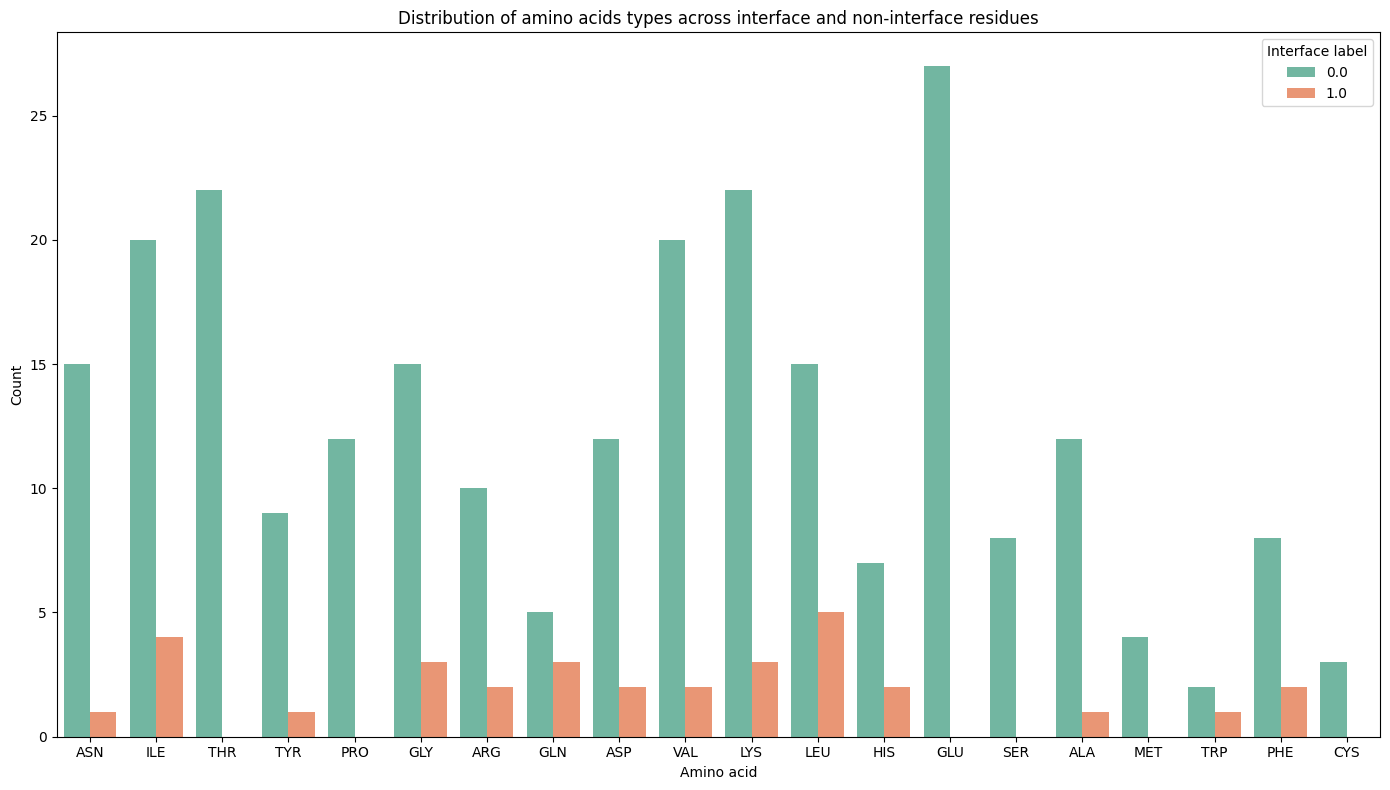

In [31]:
extracted_amino_acids = [s.split(":")[1] for s in torch_geometric_graph.node_id]

data_with_aa = {"amino acid": extracted_amino_acids, "interface labels": torch_geometric_graph.y}

plt.figure(figsize=(14, 8))
sns.countplot(x="amino acid", hue="interface labels", data=data_with_aa, palette="Set2")
plt.title("Distribution of amino acids types across interface and non-interface residues")
plt.ylabel("Count")
plt.xlabel("Amino acid")
plt.legend(title="Interface label", loc='upper right')
plt.tight_layout()
plt.show()

## Creating a Dataset class

The `torch_geometric.data.Dataset` class is a standard way of representing a graph dataset in PyTorch. It is an abstract class that you can subclass to create your own dataset. Here's what the typical architecture of a dataset looks like ([documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Dataset.html#torch_geometric.data.Dataset)):

- download(): function to download the dataset (in our case `dataset.txt`) and save files into 'self.raw_dir' (in our case as pickle files of graphein graph and interface labels)
- process(): function to process the data from `self.raw_dir` to torch-geometric `Data` objects, saved in `self.processed_dir`
- property functions: raw_file_names, processed_file_names which return the names of the raw and processed files
- len(): function to return the number of graphs in the dataset
- get(): function to return the `Data` object at a given index  

In [9]:
class ProteinDataset(Dataset):
    """
    torch-geometric Dataset class for loading protein files as graphs.
    """
    def __init__(self, root,
                 protein_names: list):
        columns = [
            "coords",
            "edge_index",
            "kind",
            "node_id",
            "residue_number",
            "amino_acid_one_hot",
            "meiler"
        ]
        self.convertor = GraphFormatConvertor(src_format="nx", dst_format="pyg", columns=columns, verbose = None)
        self.protein_names = protein_names
        super(ProteinDataset, self).__init__(root)

    def download(self):
        for protein_name in self.protein_names:
            output = Path(self.raw_dir) / f'{protein_name}.pkl'
            if not output.exists():
                pdb_id, chain = protein_name.split("_")
                graphein_graph, interface_labels = dataloader.load_graph(pdb_id, chain)
                with open(output, "wb") as f:
                    pickle.dump((graphein_graph, interface_labels), f)

    @property
    def raw_file_names(self):
        return [Path(self.raw_dir) / f"{protein_name}.pkl" for protein_name in self.protein_names if (Path(self.raw_dir) / f"{protein_name}.pt").exists()]

    @property
    def processed_file_names(self):
        return [Path(self.processed_dir) / f"{protein_name}.pt" for protein_name in self.protein_names if (Path(self.processed_dir) / f"{protein_name}.pt").exists()]

    def process(self):
        for protein_name in self.protein_names:
            output = Path(self.processed_dir) / f'{protein_name}.pt'
            if not output.exists():
                with open(Path(self.raw_dir) / f"{protein_name}.pkl", "rb") as f:
                    graphein_graph, interface_labels = pickle.load(f)
                torch_graph = graphein_to_torch_graph(graphein_graph, interface_labels, convertor=self.convertor)
                torch.save(torch_graph, output)

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(self.processed_file_names[idx])
        return data


Let's make our dataset!

In [10]:
with open('dataset.txt') as f:
    protein_names = [line.strip() for line in f]

dataset = ProteinDataset(root='./test_data',
                         protein_names=protein_names[:200])


Processing...
Done!


In [88]:
dataset

ProteinDataset(188)

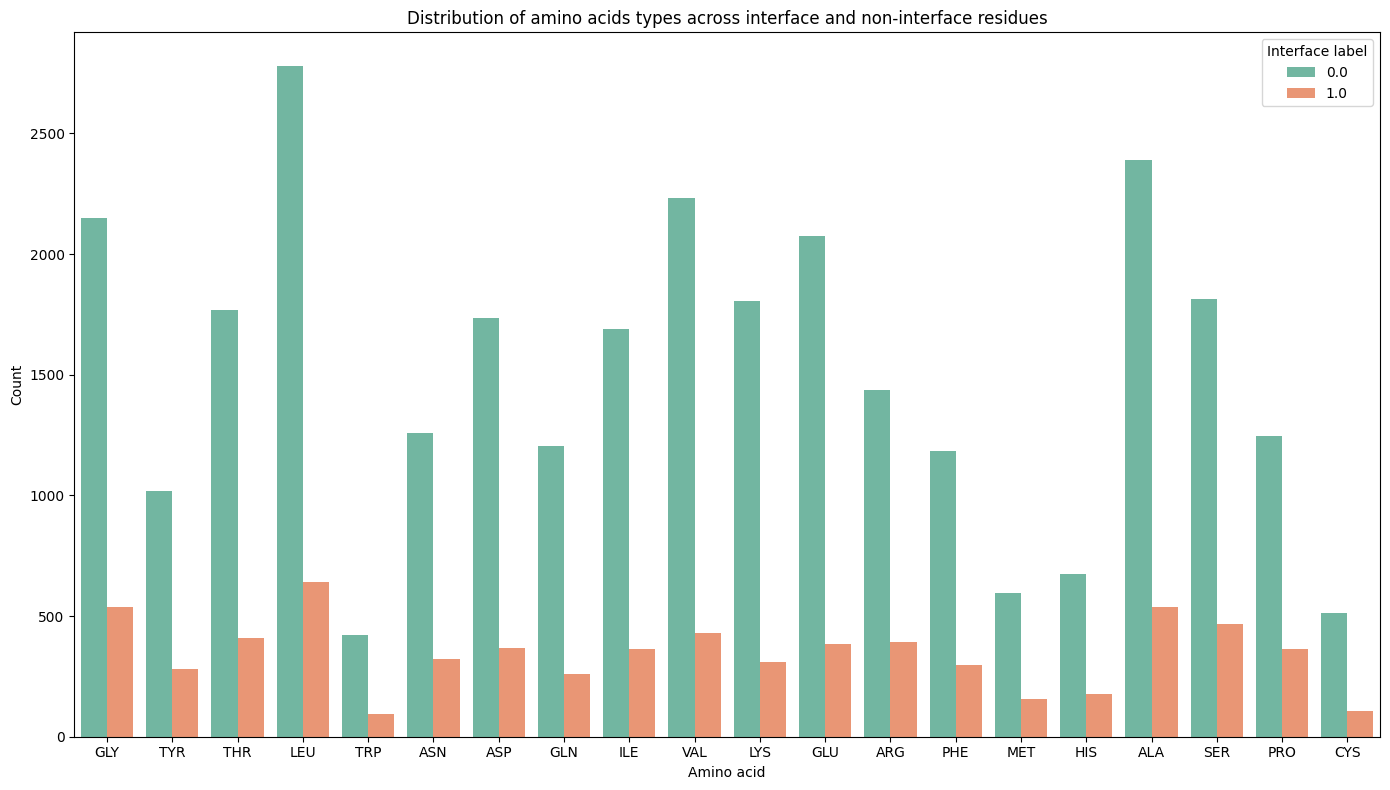

In [89]:
all_amino_acids = []
all_interface_labels = []

for torch_graph in dataset:
    extracted_amino_acids = [s.split(":")[1] for s in torch_graph.node_id]
    all_amino_acids.extend(extracted_amino_acids)
    all_interface_labels.extend(torch_graph.y.tolist())

data_with_aa = {
    "amino acid": all_amino_acids,
    "interface labels": all_interface_labels
}

plt.figure(figsize=(14, 8))
sns.countplot(x="amino acid", hue="interface labels", data=data_with_aa, palette="Set2")
plt.title("Distribution of amino acids types across interface and non-interface residues")
plt.ylabel("Count")
plt.xlabel("Amino acid")
plt.legend(title="Interface label", loc='upper right')
plt.tight_layout()
plt.show()

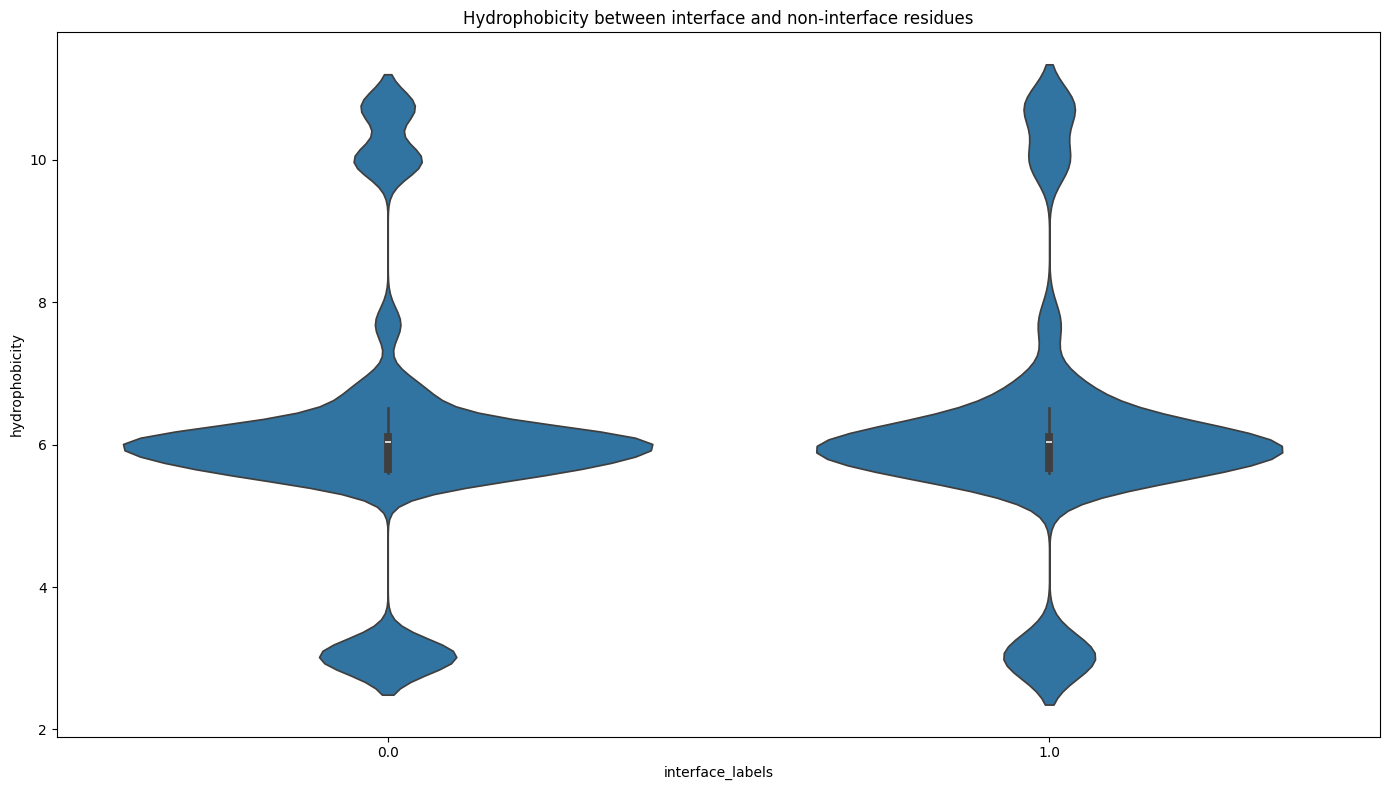

In [97]:
hydrophobicity = []
all_interface_labels = []

for torch_graph in dataset:
    hydrophobicity.extend(torch_graph.meiler[:,4].tolist())
    all_interface_labels.extend(torch_graph.y.tolist())

data = {
    "hydrophobicity": hydrophobicity,
    "interface_labels": all_interface_labels
}

plt.figure(figsize=(14, 8))
sns.violinplot(x="interface_labels", y="hydrophobicity", data=data)
plt.title("Hydrophobicity between interface and non-interface residues")
plt.tight_layout()
plt.show()

In [86]:
# TODO: add functions to src/dataloader.py

This puts together what we've been implementing for loading proteins as graphs with graphein, converting those into PyTorch-geometric Data objects and then wrapping those into a PyTorch Dataset. 

Graphein also has a built-in `ProteinGraphDataset` class that combines these steps. It also has some nice features like (1) the ability to load a dataset of proteins from both the PDB or AlphaFold Database directory of PDB files, (2) the ability to apply custom transformations from your bioinformatics tools of choice to the PDB files (with the `pdb_transform` argument).

## Bonus
- pre-transforms and transforms
- how to use the `ProteinGraphDataset` class to include AlphaFold models